In [264]:
import pandas as pd
#from binance.spot import Spot as Client
from binance.client import Client
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import ta

In [265]:
import algo.calculate

In [ ]:
import importlib, data.read
importlib.reload(data.read)
importlib.reload(algo.calculate)

In [ ]:
df_all = data.read.df_okx_20231220_1225

### backtest algo

In [257]:
importlib.reload(algo.calculate)

<module 'algo.calculate' from '/home/junlim/projects/kristjan_swing/algo/calculate.py'>

In [255]:
def strategy_backtest(data, portfolio_value, risk_trade_percentage, min_days_in_consolidation, max_days_in_consolidation, min_perc_increase):
    trades = pd.DataFrame(columns=['Asset', 'Entry Date', 'Exit Date', 'Entry Price', 'Exit Price', 'Dollar Return', 'Outcome'])
    open_trades = pd.DataFrame(columns=['Asset', 'Entry Date', 'Entry Price', 'Current Price', 'Stop Loss', 'Potential Dollar Return'])
    for asset, df in data.items():
        df, new_trades, new_open_trades = algo.calculate.trade_asset(asset, df, float(portfolio_value / len(data)), risk_trade_percentage, min_days_in_consolidation, max_days_in_consolidation, min_perc_increase)
        trades = pd.concat([trades, new_trades], ignore_index=True)
        open_trades = pd.concat([open_trades, new_open_trades], ignore_index=True)

    return trades, open_trades

In [260]:
def describe_backtest(data_dict, trades, open_trades, portfolio_value):
    # Sort trades DataFrame by 'Entry Date'
    trades.sort_values(by='Entry Date', inplace=True)
    # Create a figure for individual portfolio plots
    plt.figure(figsize=(12, 8))
    
    # Configure the individual portfolio plot
    plt.title('Individual Portfolio Performance by Asset')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    
    # Initialize a DataFrame to store aligned portfolio values for all assets
    all_portfolios = pd.DataFrame()
    
    # Plot portfolio value for each asset and align for average	calculation
    for asset, df in data_dict.items():
        if df['portfolio'].iloc[-1] == df['portfolio'].iloc[0]:
            continue
        plt.plot(df['date'], df['portfolio'], label=f'{asset}')
        all_portfolios[asset] = df.set_index('date')['portfolio'] - portfolio_value
    #all_portfolios.fillna(float(portfolio_value / len(data_dict)), inplace=True)
    all_portfolios.fillna(method='ffill', inplace=True)
    
    plt.legend()
    plt.grid(True)
    plt.show() # Show the plot for individual portfolios
    
    # Create a new figure for the average portfolio plot
    plt.figure(figsize=(12, 8))
    # Calculate the average portfolio value
    all_portfolios['Average Portfolio'] = all_portfolios.sum(axis=1)
    # Plot the average portfolio value
    plt.plot(all_portfolios.index, all_portfolios['Average Portfolio'], label='Average Portfolio', color='black', linewidth=2)
    
    # Configure the average portfolio plot
    plt.title('Average Portfolio Performance')
    plt.xlabel('Date')
    plt.ylabel('Average Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return all_portfolios

### load the data from api

In [3]:
def get_spot_data(client, timeframe, days_range, selected_assets):
	spot_data = {}

	# Get the current date
	today_date = datetime.date.today()
	# Calculate the trade date for the specified number of days in the past

	trade_date_data = today_date - relativedelta(days=days_range)

	# Store the arguments for the get_historical_klines() method in variables
	timeframe_for_data = timeframe
	start_date_for_data = str(trade_date_data)

	# Loop through the selected symbols and get the daily data for each one
	for symbol in selected_assets:
		print(f"Extracting data for: {symbol}")
		# Initialize an empty list to store the data for the
		symbol
		symbol_data = []

		# Get the daily data for the symbol
		data = client.get_historical_klines(symbol, timeframe_for_data, start_date_for_data)

		# Loop through the daily data and extract the relevant information
		for daily_data in data:
			# Extract the timestamp, open price, high price, low price, close price, and volume
			timestamp, open_price, high_price, low_price, close_price, volume = daily_data[:6]

			# Convert the timestamp to a date
			date = datetime.datetime.fromtimestamp(int(timestamp) / 1000)
			# Add the cleaned data to the list
			symbol_data.append({
				'date': date,
				'asset': symbol,
				'open': float(open_price),
				'high': float(high_price),
				'low': float(low_price),
				'close': float(close_price),
				'volume': float(volume)
			})

		# Convert the data for the symbol to a dataframe
		spot_data[symbol] = pd.DataFrame(symbol_data)

		print(f"Finished Extracting data for: {symbol}")

	return spot_data

In [14]:
def connect_to_binance(API_KEY, SECRET_API_KEY):
	return Client(API_KEY, SECRET_API_KEY)

######################################################
# USER INPUT SECTION
######################################################
# Binance API Settings
# ---------------------
# Provide your Binance API key and secret key below.
# These keys are necessary to access financial data through the Binance API.
API_KEY = ''
SECRET_API_KEY = ''

# Trading Portfolio and Strategy Settings
# ---------------------------------------
# Define your initial portfolio value, risk percentage per trade, and
# parameters for the trading strategy's consolidation period and minimum
# percentage increase for asset selection.
# These settings will influence how the trading strategy operates.

# Fetching and Analyzing Market Data
# ----------------------------------
# Fetch market data for a predefined list of assets from Binance and
# perform strategy backtesting based on the specified parameters.
# This process will gather historical data for each asset and apply the
# trading strategy to analyze potential trades.
# Connect to Binance using API keys
client = connect_to_binance(API_KEY, SECRET_API_KEY)

# List of cryptocurrency pairs to analyze
selected_assets = ["BTCUSDT", "ETHUSDT", "SOLUSDT", "BNBUSDT",\
	"XRPUSDT", "ADAUSDT", "AVAXUSDT", "DOGEUSDT",\
	"DOTUSDT", "TRXUSDT", "LINKUSDT", "MATICUSDT",\
	"LTCUSDT", "UNIUSDT", "BCHUSDT", "ICPUSDT",\
	"XLMUSDT", "NEARUSDT", "ATOMUSDT","INJUSDT"]

# Fetch historical spot data for selected assets
# 3000
data = get_spot_data(client, "1d", 3000, selected_assets)

Extracting data for: BTCUSDT
Finished Extracting data for: BTCUSDT
Extracting data for: ETHUSDT
Finished Extracting data for: ETHUSDT
Extracting data for: SOLUSDT
Finished Extracting data for: SOLUSDT
Extracting data for: BNBUSDT
Finished Extracting data for: BNBUSDT
Extracting data for: XRPUSDT
Finished Extracting data for: XRPUSDT
Extracting data for: ADAUSDT
Finished Extracting data for: ADAUSDT
Extracting data for: AVAXUSDT
Finished Extracting data for: AVAXUSDT
Extracting data for: DOGEUSDT
Finished Extracting data for: DOGEUSDT
Extracting data for: DOTUSDT
Finished Extracting data for: DOTUSDT
Extracting data for: TRXUSDT
Finished Extracting data for: TRXUSDT
Extracting data for: LINKUSDT
Finished Extracting data for: LINKUSDT
Extracting data for: MATICUSDT
Finished Extracting data for: MATICUSDT
Extracting data for: LTCUSDT
Finished Extracting data for: LTCUSDT
Extracting data for: UNIUSDT
Finished Extracting data for: UNIUSDT
Extracting data for: BCHUSDT
Finished Extracting dat

In [9]:
import pickle

In [15]:
pickle.dump(data, open('data/data.pickle', 'wb'))

### load the cached data

In [121]:
data_dict = pickle.load(open('data/data.pickle', 'rb'))

In [122]:
data_dict

{'BTCUSDT':                     date    asset      open      high       low     close  \
 0    2017-08-16 20:00:00  BTCUSDT   4261.48   4485.39   4200.74   4285.08   
 1    2017-08-17 20:00:00  BTCUSDT   4285.08   4371.52   3938.77   4108.37   
 2    2017-08-18 20:00:00  BTCUSDT   4108.37   4184.69   3850.00   4139.98   
 3    2017-08-19 20:00:00  BTCUSDT   4120.98   4211.08   4032.62   4086.29   
 4    2017-08-20 20:00:00  BTCUSDT   4069.13   4119.62   3911.79   4016.00   
 ...                  ...      ...       ...       ...       ...       ...   
 2318 2023-12-21 19:00:00  BTCUSDT  43861.79  44398.26  43412.54  43969.04   
 2319 2023-12-22 19:00:00  BTCUSDT  43969.04  43988.68  43291.10  43702.16   
 2320 2023-12-23 19:00:00  BTCUSDT  43702.15  43946.00  42500.00  42991.50   
 2321 2023-12-24 19:00:00  BTCUSDT  42991.50  43802.32  42720.43  43576.13   
 2322 2023-12-25 19:00:00  BTCUSDT  43576.12  43592.68  41637.60  42273.17   
 
             volume  
 0       795.150377  
 1     

### apply backtest to okx 1minutes data

In [261]:
def strategy_backtest_from_df(df_all, portfolio_value, risk_trade_percentage, min_days_in_consolidation, max_days_in_consolidation, min_perc_increase):
    trades = pd.DataFrame(columns=['Asset', 'Entry Date', 'Exit Date', 'Entry Price', 'Exit Price', 'Dollar Return', 'Outcome'])
    open_trades = pd.DataFrame(columns=['Asset', 'Entry Date', 'Entry Price', 'Current Price', 'Stop Loss', 'Potential Dollar Return'])
    data_dict = {}
    
    for asset, df in df_all.groupby('asset'):
        df, new_trades, new_open_trades = algo.calculate.trade_asset(asset, df.reset_index().drop('index', axis=1), portfolio_value, risk_trade_percentage, min_days_in_consolidation, max_days_in_consolidation, min_perc_increase)
        data_dict[asset] = df
        trades = pd.concat([trades, new_trades], ignore_index=True)
        open_trades = pd.concat([open_trades, new_open_trades], ignore_index=True)

    return data_dict, trades, open_trades

In [270]:
# Initial value of the trading portfolio in dollars
portfolio_value = 100000
# Maximum percentage of the portfolio value to risk on a single trade
risk_trade_percentage = 1
# Minimum number of days for an asset to be considered in a consolidation period
min_days_in_consolidation = 7
# Maximum number of days for an asset to remain in the consolidation period
max_days_in_consolidation = 56
# Minimum percentage increase in asset price to consider for trading
min_perc_increase = 3

In [271]:
# Perform backtest of the trading strategy with the fetched data
data_dict_, closed_trades_, open_trades_ = strategy_backtest_from_df(df_all, portfolio_value, risk_trade_percentage, min_days_in_consolidation, max_days_in_consolidation, min_perc_increase)

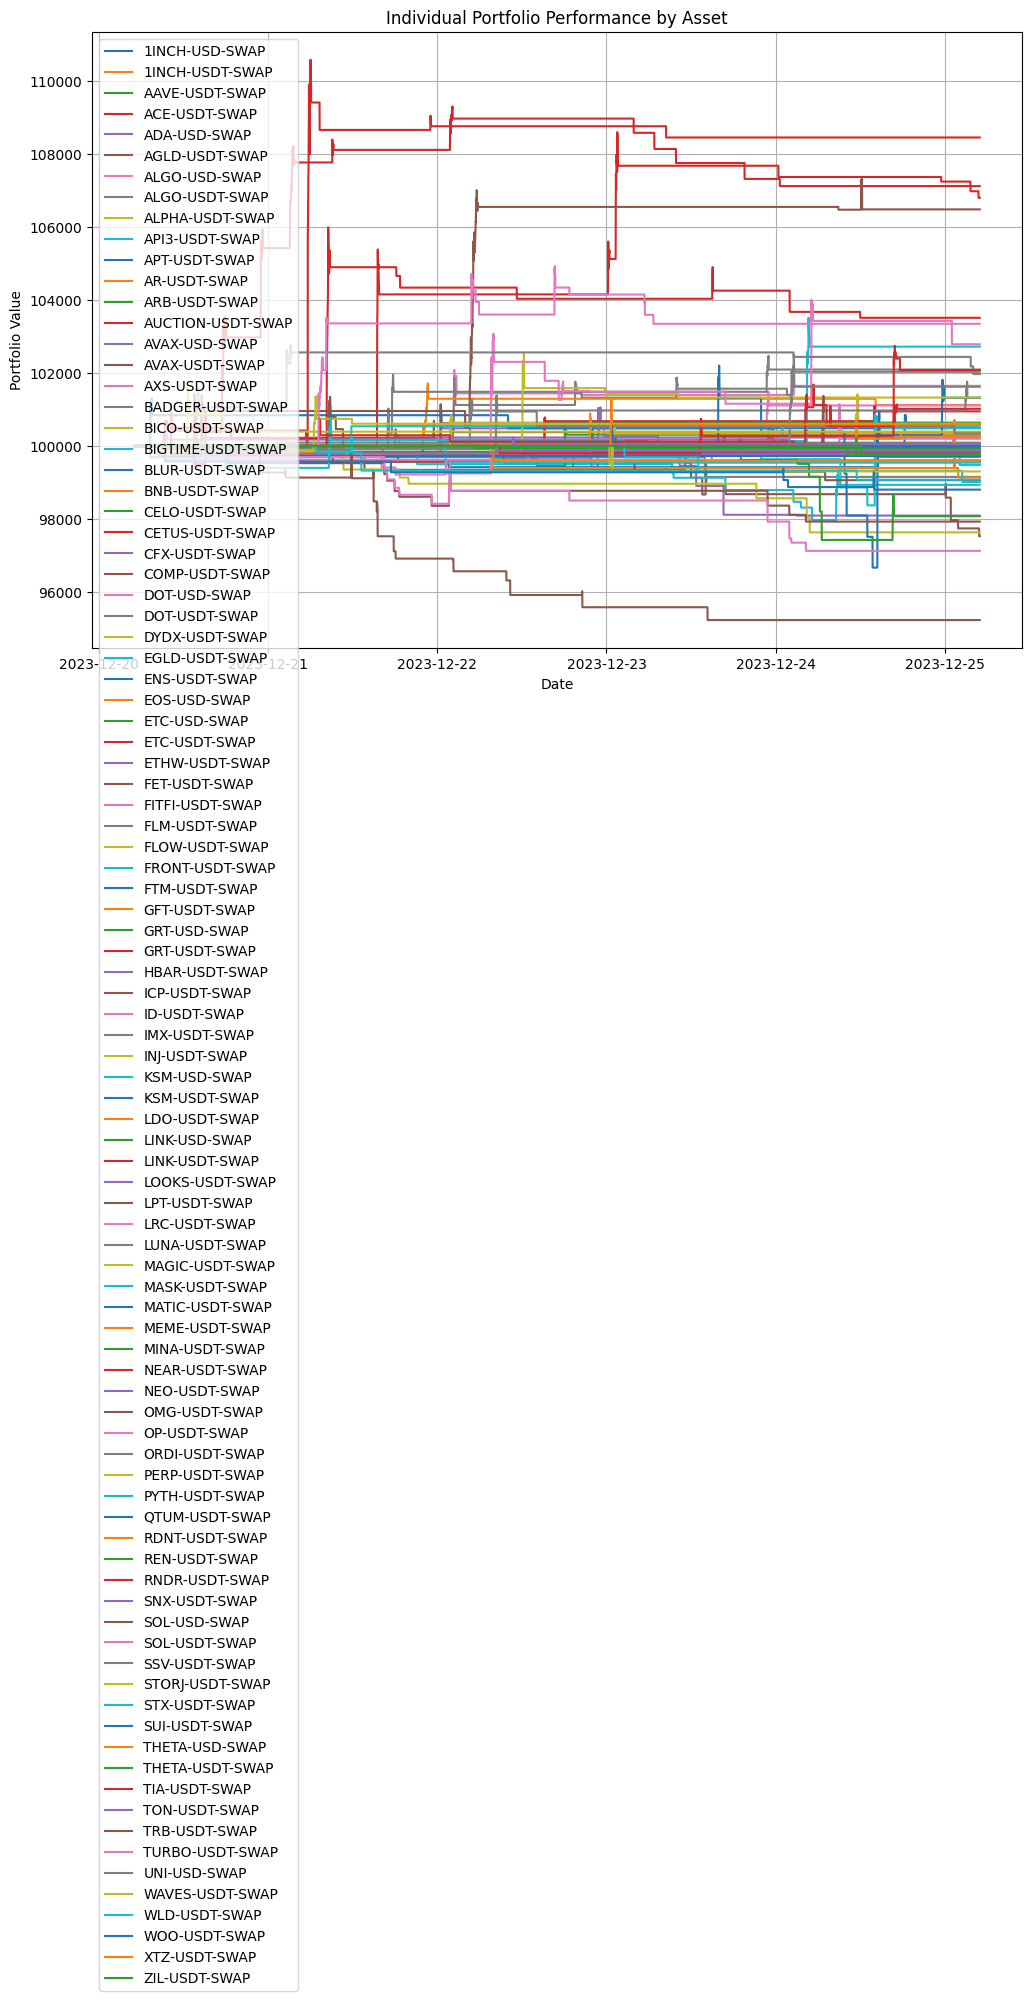

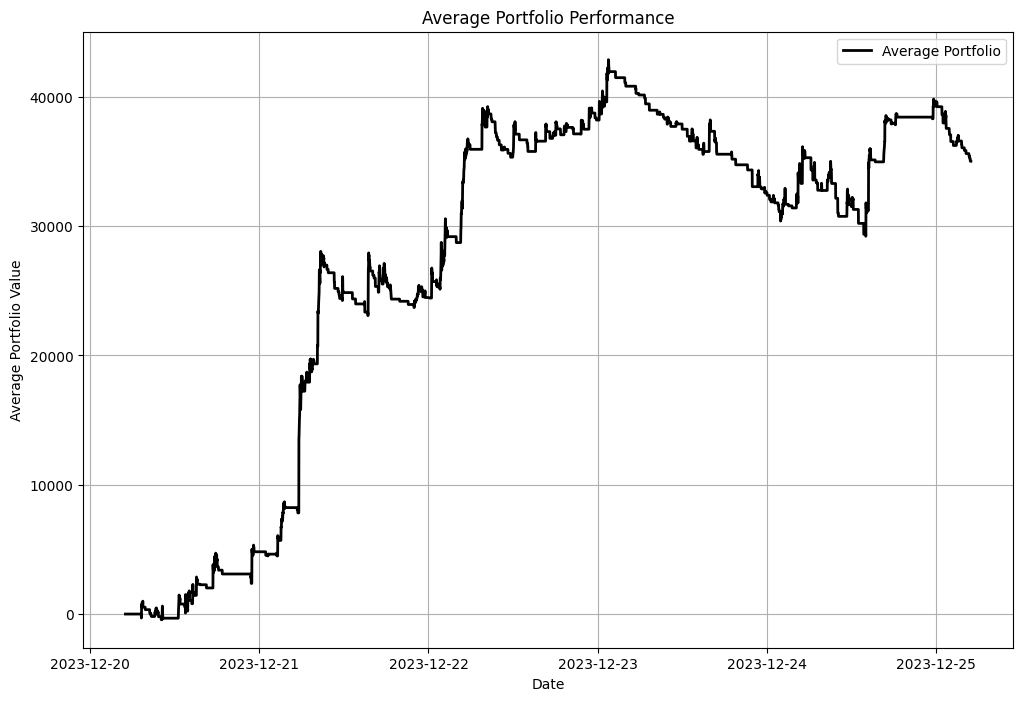

In [272]:
# min_perc_increase = 3
all_portfolios_ = describe_backtest_(data_dict_, closed_trades_, open_trades_, portfolio_value)

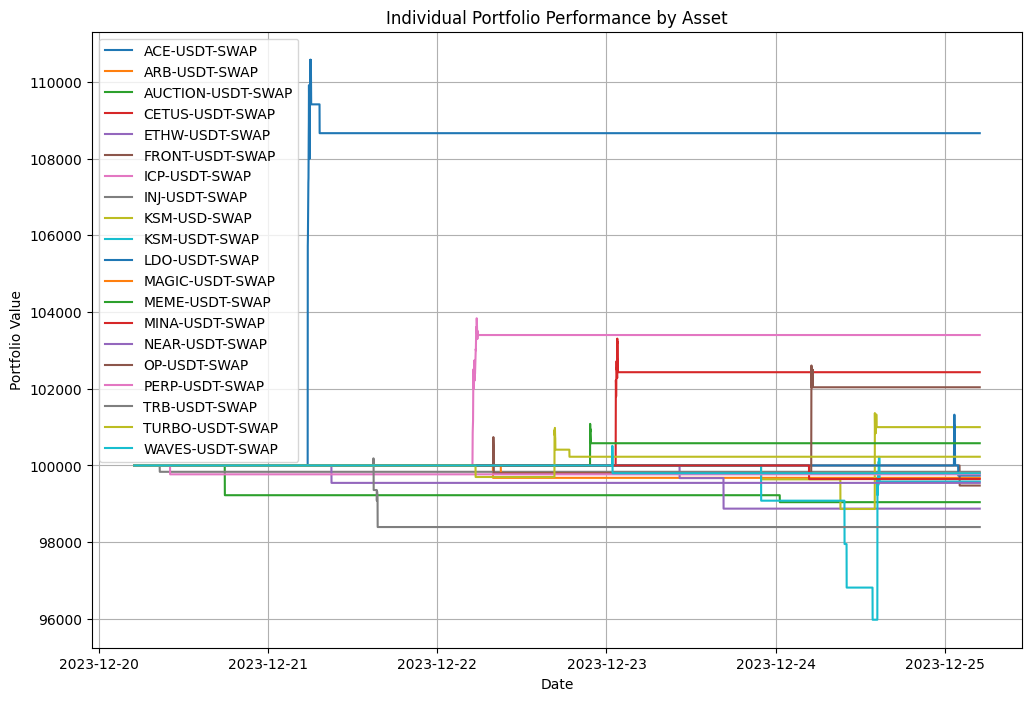

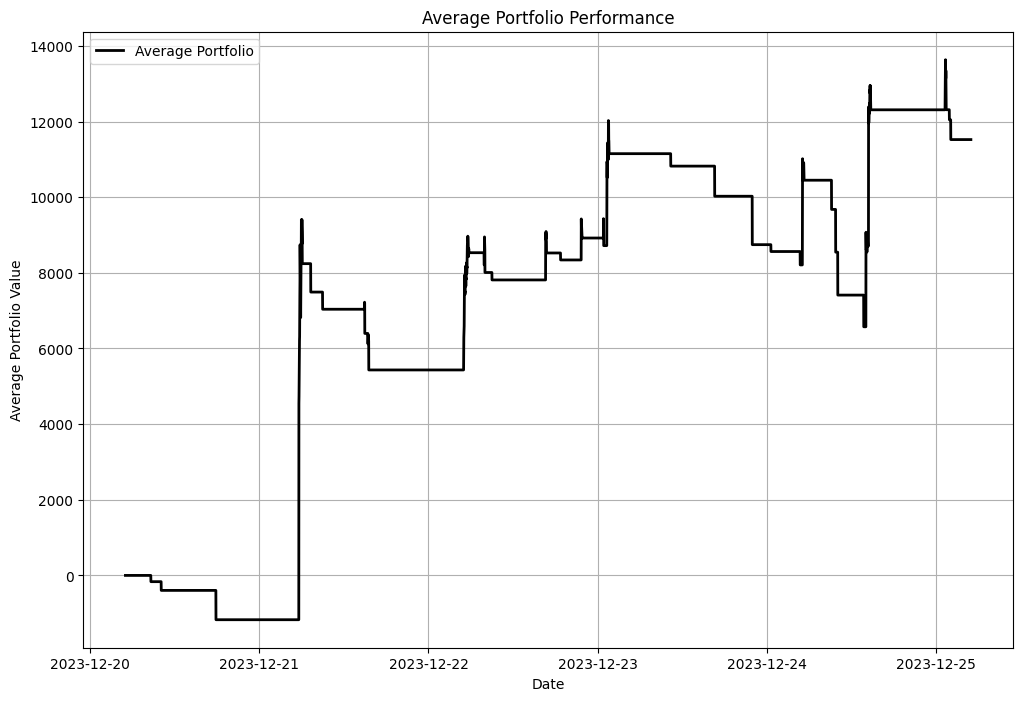

In [268]:
# min_perc_increase = 7
all_portfolios_ = describe_backtest_(data_dict_, closed_trades_, open_trades_, portfolio_value)

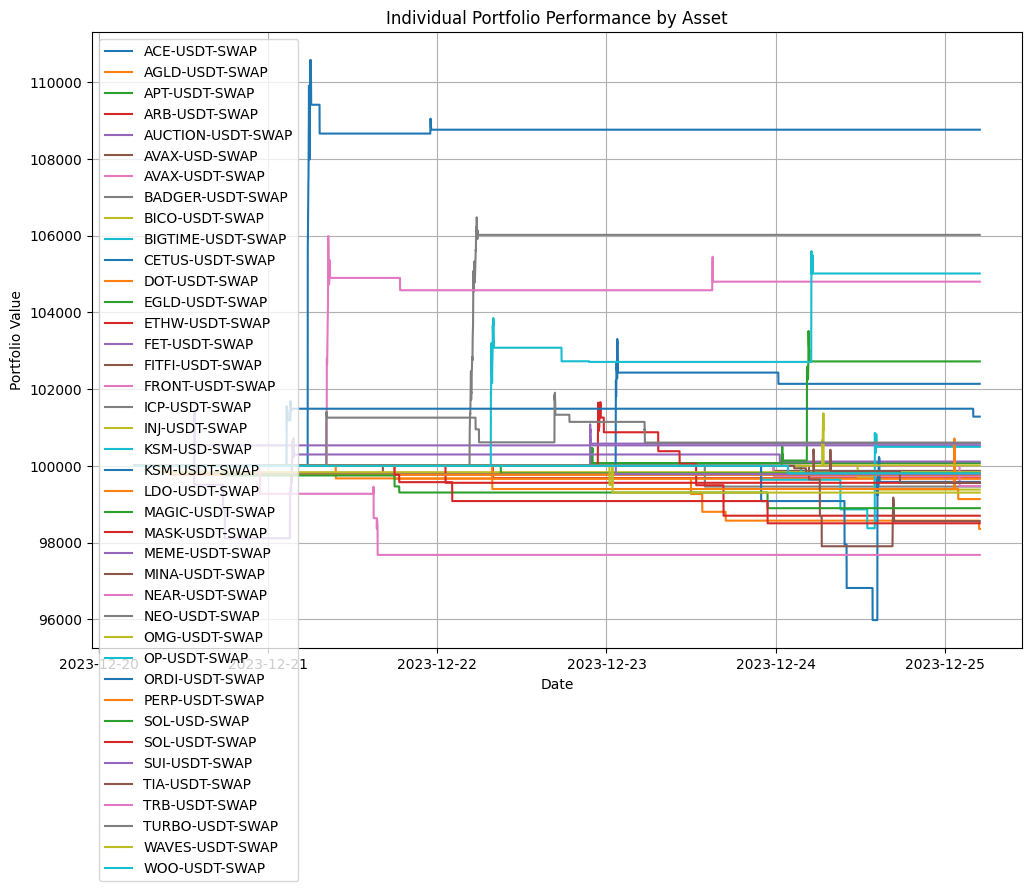

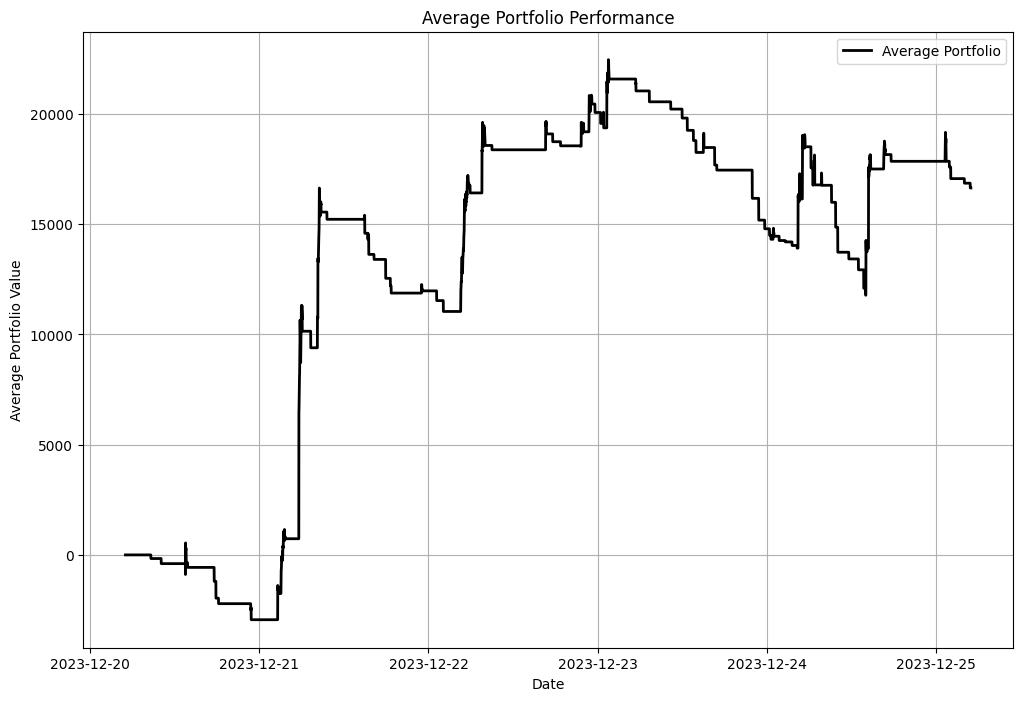

In [252]:
# min_perc_increase = 5
all_portfolios_ = describe_backtest_(data_dict_, closed_trades_, open_trades_, portfolio_value)

### backtest

In [158]:
# Initial value of the trading portfolio in dollars
portfolio_value = 100000
# Maximum percentage of the portfolio value to risk on a single trade
risk_trade_percentage = 1
# Minimum number of days for an asset to be considered in a consolidation period
min_days_in_consolidation = 7
# Maximum number of days for an asset to remain in the consolidation period
max_days_in_consolidation = 56
# Minimum percentage increase in asset price to consider for trading
min_perc_increase = 30

In [124]:
# Perform backtest of the trading strategy with the fetched data
closed_trades, open_trades = strategy_backtest(data_dict, portfolio_value, risk_trade_percentage, min_days_in_consolidation, max_days_in_consolidation, min_perc_increase)

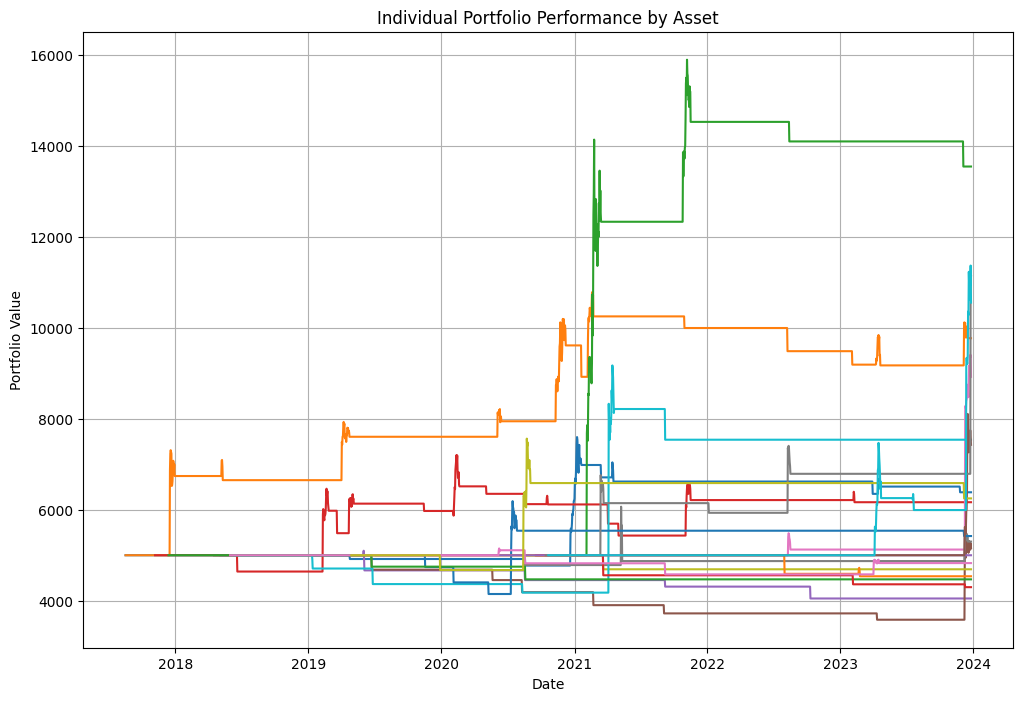

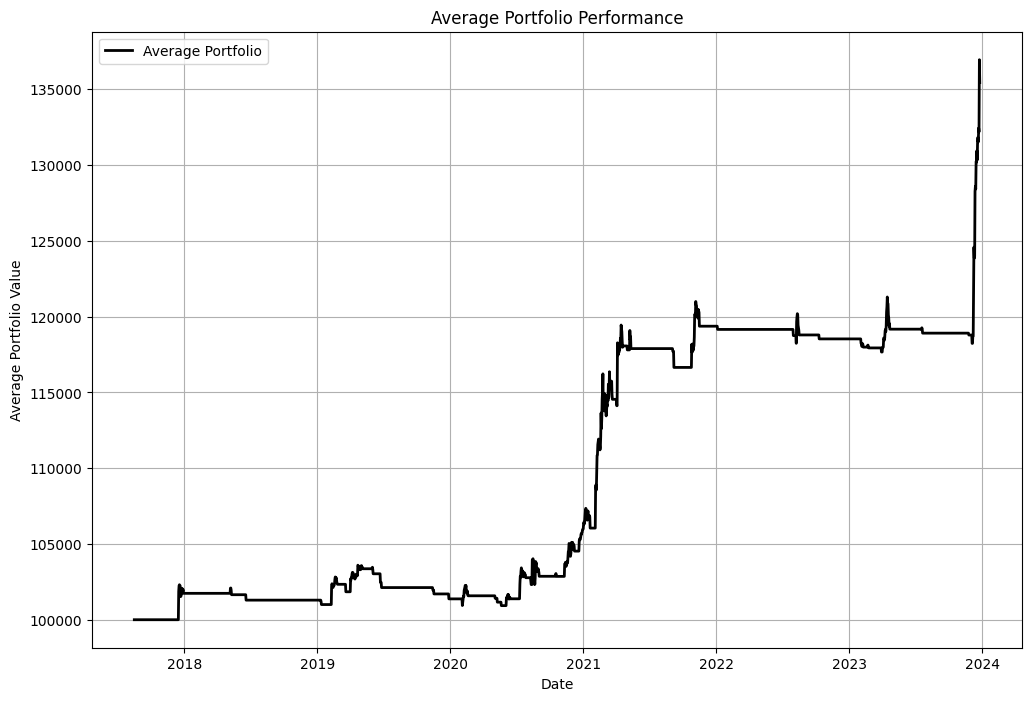

In [133]:
all_portfolios = describe_backtest(data_dict, closed_trades, open_trades)